# Preclassification of pneumonia by chest X-ray
### Group 6 of intro2NNs
### Zhenge Wang, Xuanyu Pan, Chaochen Hu,  Jiaqi Xue

## Introduction

### Background

Coronavirus disease 2019 (COVID-19) is an infectious disease caused by severe acute respiratory syndrome coronavirus 2 (SARS-CoV-2). It was first identified in December 2019 in Wuhan, Hubei, China, and has resulted in an ongoing pandemic. On 5 October, the WHO said that one in ten people around the world (around 800 million) may have been infected with COVID–19.As of 7 October 2020, 35.6 million cases have been reported across 188 countries and territories with more than 1.04 million deaths; more than 24.8 million people have recovered.[<sup>1</sup>](#refer_achor)

The standard method of detection is a real-time reverse transcription-polymerase chain reaction (rRT-PCR). The test is typically done on respiratory samples obtained by a nasopharyngeal swab; however, a nasal swab or sputum sample may also be used. Results are generally available within a few hours to two days. Due to sampling errors and other reasons, the detection rate of the PCR test is not high, and there is a certain possibility of missing detection. Later, experts suggested the introduction of a CT scan as an auxiliary diagnostic criterion.[<sup>2</sup>](#refer_achor)

But there comes a problem, the capacity of PCR and CT scans are limited or even non-existent in someplace, since not every hospital has a laboratory with PCR capability and CT machine, which are both very expensive. What's more, even they do have these machines, it is still far from enough to handle an outbreak like Wuhan. But X-ray machines are cheaper and more widely available than CT machines, and perhaps we can make a preliminary classification of patients with ordinary chest radiography. Because chest radiographs can tell if a patient has pneumonia and what type of pneumonia, viral pneumonia or bacterial pneumonia. In this way, we can further isolate patients with viral pneumonia.

In this project, we will use the CNN models to do preclassification of pneumonia based chest X-ray figures, which could play an important role in the early screening of COVID-19.

## Data collection
Our dataset was extracted from [kaggle](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia), which, originally, includes 5863 Chest X-Ray images and 2 categories (Pneumonia/Normal). Because our goal was not only to detect pneumonia, but also to determine what type of pneumonia it was, we artificially divided the data set into three categories according to the file name: viral pneumonia, bacterial pneumonia, and normal.
<br/><br/>  These chest X-ray images (anterior-posterior) were selected from retrospective cohorts of pediatric patients of one to five years old from Guangzhou Women and Children’s Medical Center, Guangzhou. All chest X-ray imaging was generated as part of patients’ routine clinical care.
<br/><br/>
  For the analysis of chest x-ray images, all chest radiographs were initially screened for quality control by removing all low quality or unreadable scans. The diagnoses for the images were then graded by two expert physicians before being cleared for training the AI system.[<sup>3</sup>](#refer_achor)
  
  This dataset is a part of a bigger dataset, there is the acknowledgment  of the original dataset.
  
  Data: https://data.mendeley.com/datasets/rscbjbr9sj/2

  License: CC BY 4.0

  Citation: http://www.cell.com/cell/fulltext/S0092-8674(18)30154-5

In [1]:
#do some import
from sklearn.metrics import accuracy_score,confusion_matrix
import matplotlib.pyplot as plt
from tensorflow import keras
from PIL import Image
import numpy as np
import pandas as pd
import math
from tf_keras_vis.utils import normalize
from tf_keras_vis.saliency import Saliency
from tf_keras_vis.gradcam import Gradcam
import os
import seaborn
import tensorflow as tf

## Data exploration

In [ ]:
#for colab use
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Mounted at /gdrive
/gdrive


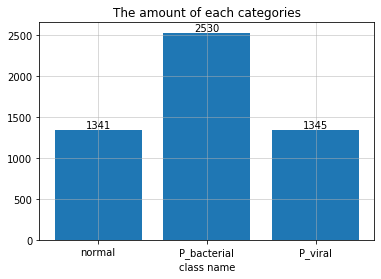

In [ ]:
train_dir='D:/chest/train'
validation_dir='D:/chest/test'
#train_dir='/gdrive/My Drive/data/train'
#validation_dir='/gdrive/My Drive/data/test'
categories=os.listdir(train_dir)
nlist=[]
for i in categories:
    nlist.append(len(os.listdir(train_dir+'/'+i)))
plt.bar(categories,nlist,yerr=2)
for i in range(3):
    plt.text(categories[i],nlist[i],nlist[i],ha='center', va='bottom')
plt.grid(alpha=0.6)
plt.title('The amount of each categories')
plt.xlabel('class name')
plt.show()

Firstly, we count the number of each category. That's important, since the unbalanced sample size distribution like this dataset will lead to a large deviation in the model results. As a result, we should set a class weight for the next training process based on this distribution, which is shown in the next code cell.

In [ ]:
class_weight={0:0.5,1:1.0,2:1}

Then, we pick three X-ray images from different class to see what difference do they have.

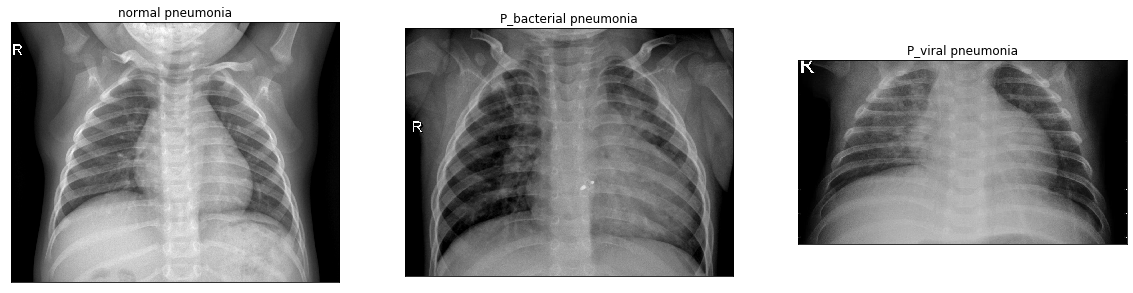

In [ ]:
subplot_args = { 'nrows': 1, 'ncols': 3, 'figsize': (20,10),
                 'subplot_kw': {'xticks': [], 'yticks': []} }

fig,ax=plt.subplots(**subplot_args)
for i in range(3):
    path=train_dir+'/'+categories[i]
    ax[i].imshow(Image.open(path+'/'+os.listdir(path)[2]),cmap='gray')
    ax[i].set_title(str(categories[i])+' pneumonia')

Upper image is a sequence of normal, viral, and bacterial chest radiographs.

The normal chest X-ray (left panel) depicts clear lungs without any areas of abnormal opacification in the image.Bacterial pneumonia (middle) typically exhibits a focal lobar consolidation, in this case in the right upper lobe (white arrows), whereas viral pneumonia (right) manifests with a more diffuse ‘‘interstitial’’ pattern in both lungs.[<sup>1</sup>](#refer_achor) With these different pattern between them, we can train a CNN model to catch these features then do classfication work.

## Load the data and data augmantation

In order to load data more efficient, we use ImageDataGenerator to do the loading work. Moreover,ImageDataGenerator not only can help us load image data, but also can do data preprocessing and data augmatation at the same time. We used two training dataset, which are the original dataset and augmantated training dataset. 

In [ ]:

train_dir='D:/chest/train'
validation_dir='D:/chest/test'
#train_dir='/gdrive/My Drive/data/train'
#validation_dir='/gdrive/My Drive/data/test'

train_datagen=keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255.0,
                                rotation_range=10,
                                 width_shift_range=0.1,            
                                 height_shift_range=0.1,
                                 horizontal_flip=True,
                                 fill_mode='nearest')
                                 
validation_datagen=keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255.0,)
#train_generator=validation_datagen.flow_from_directory(train_dir,target_size=(150,150),class_mode='categorical',batch_size=128)
trainaug_generator=train_datagen.flow_from_directory(train_dir,target_size=(150,150),class_mode='categorical',batch_size=128)
validation_generator=validation_datagen.flow_from_directory(validation_dir,target_size=(150,150),class_mode='categorical',batch_size=32,seed=20)

Found 5216 images belonging to 3 classes.
Found 5216 images belonging to 3 classes.
Found 624 images belonging to 3 classes.


Below is some sample data generated by ImageDataGenerator.

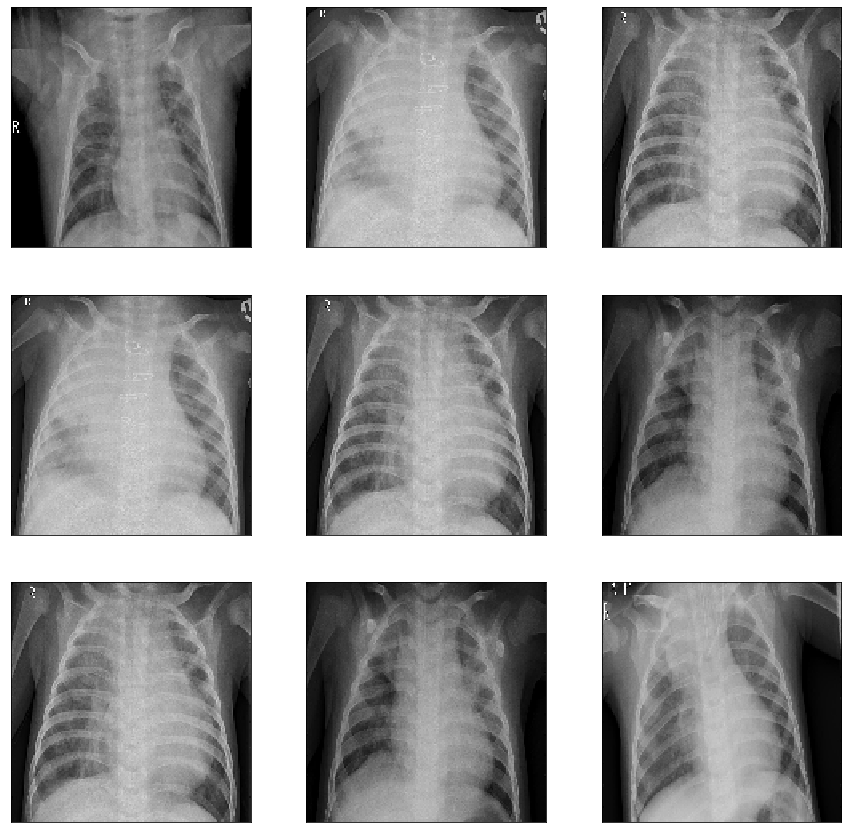

In [ ]:
#展示数据扩增后的结果
subplot_args = { 'nrows': 3, 'ncols': 3, 'figsize': (15,15),
                 'subplot_kw': {'xticks': [], 'yticks': []} }

fig,ax=plt.subplots(**subplot_args)
for i in range(3):
    for j in range(3):
        ax[i][j].imshow(train_generator[0][0][i+j],cmap='gray')

## Classification by CNN
Firstly, we built a CNN model by ourself as our baseline, and use recall of viral pneumonia,Normal,pneumonia and categorical accuracy as metrics.Then we used pre-trained model xception.

In [2]:
virusrecall=keras.metrics.Recall(class_id=1,name='viral_recall')
normrecall=keras.metrics.Recall(class_id=2,name='norm_recall')
Precall=keras.metrics.Recall( top_k=2,name='P_recall')

In [ ]:
#define our coustom earlystopping
'''Our custom EarlyStopping, which monitors the average of ecall of viral pneumonia,
   Normal,pneumonia and categorical accuracy'''
class myEarlyStopping(keras.callbacks.Callback):
    def __init__(self, patience=0):
        super(myEarlyStopping, self).__init__()
        self.patience = patience
        # best_weights to store the weights at which the minimum loss occurs.
        self.best_weights = None
    
    def on_train_begin(self, logs=None):
        # The number of epoch it has waited when loss is no longer minimum.
        self.wait = 0
        # The epoch the training stops at.
        self.stopped_epoch = 0
        # Initialize the best as infinity.
        self.best = 0
        
    def on_epoch_end(self, epoch, logs=None):
        categorical_accuracy=logs.get("val_categorical_accuracy")
        viral_recall=logs.get("val_viral_recall")
        P_recal=logs.get("val_P_recall")
        n_recal=logs.get("val_norm_recall")
        current = (categorical_accuracy+viral_recall+n_recal+P_recal)/3
        # if categorical_accuracy>=0.8 and viral_recall>=0.8 and n_recal>=0.8 and P_recal>=0.9:
        #     self.model.stop_training = True
        #     print("Epoch %05d: early stopping:Meet the preset requirements" % (self.stopped_epoch + 1))

        if np.greater(current, self.best):
            self.best = current
            self.wait = 0
            # Record the best weights if current results is better (less).
            self.best_weights = self.model.get_weights()
        else:
            self.wait += 1
            if self.wait >= self.patience and categorical_accuracy>=0.8 and viral_recall>=0.8 and n_recal>=0.8 and P_recal>=0.9:
                self.stopped_epoch = epoch
                self.model.stop_training = True
                print("Restoring model weights from the end of the best epoch.")
                self.model.set_weights(self.best_weights)

    def on_train_end(self, logs=None):
        if self.stopped_epoch > 0:
            print("Epoch %05d: early stopping" % (self.stopped_epoch + 1))

In [3]:
def plot_hist(hist_dict):
    fig, ax = plt.subplots(2,2, figsize=(15,10))

    ax[0][1].plot(hist_dict['categorical_accuracy'])
    ax[0][1].plot(hist_dict['val_categorical_accuracy'])
    ax[0][1].set_title('Model accuracy')
    ax[0][1].set_ylabel('accuracy')
    ax[0][1].set_xlabel('epoch')
    ax[0][1].legend(['train', 'val'], loc='best')

    ax[0][0].plot(hist_dict['loss'])
    ax[0][0].plot(hist_dict['val_loss'])
    ax[0][0].set_title('Model loss')
    ax[0][0].set_ylabel('loss')
    ax[0][0].set_xlabel('epoch')
    ax[0][0].legend(['train', 'val'], loc='best')
    
    ax[1][0].plot(hist_dict['P_recall'])
    ax[1][0].plot(hist_dict['val_P_recall'])
    ax[1][0].set_title('pneumonia recall')
    ax[1][0].set_ylabel('pneumonia recall')
    ax[1][0].set_xlabel('epoch')
    ax[1][0].legend(['train', 'val'], loc='best')
    
    ax[1][1].plot(hist_dict['viral_recall'])
    ax[1][1].plot(hist_dict['val_viral_recall'])
    ax[1][1].set_title('viral recall')
    ax[1][1].set_ylabel('viral recall')
    ax[1][1].set_xlabel('epoch')
    ax[1][1].legend(['train', 'val'], loc='best')
    
    plt.show()

###  CNN built by ourself

In [3]:
model_us=keras.Sequential()
model_us.add(keras.layers.Conv2D(64,(3,3),activation='relu',input_shape=(150,150,3)))
model_us.add(keras.layers.Conv2D(64,(3,3),activation='relu',input_shape=(150,150,3)))
model_us.add(keras.layers.MaxPooling2D())
model_us.add(keras.layers.Conv2D(128,(3,3),activation='relu'))
model_us.add(keras.layers.Conv2D(128,(3,3),activation='relu'))
model_us.add(keras.layers.MaxPooling2D())
model_us.add(keras.layers.Flatten())
model_us.add(keras.layers.Dense(128,activation='relu'))
model_us.add(keras.layers.Dense(64,activation='relu'))
model_us.add(keras.layers.Dense(3,activation='softmax'))
model_us.compile(loss='categorical_crossentropy',metrics=['categorical_accuracy',virusrecall,Precall,normrecall],
                optimizer='adam')
model_us.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 64)      1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 146, 146, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 73, 73, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 71, 71, 128)       73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 69, 69, 128)       147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 34, 34, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 147968)            0

In [ ]:
Thecallback = myEarlyStopping(5)
ushistory2=model_us.fit(trainaug_generator,epochs=20,validation_data=validation_generator,class_weight=class_weight,callbacks=[callback])

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 41 steps, validate for 20 steps
Epoch 1/20
41/41 [==============================] - 82s 2s/step - loss: 0.8426 - categorical_accuracy: 0.3587 - viral_recall: 0.0253 - P_recall: 0.6472 - norm_recall: 0.0664 - val_loss: 0.9319 - val_categorical_accuracy: 0.4840 - val_viral_recall: 0.0473 - val_P_recall: 0.7228 - val_norm_recall: 0.0940
Epoch 2/20
41/41 [==============================] - 81s 2s/step - loss: 0.7197 - categorical_accuracy: 0.5704 - viral_recall: 0.1108 - P_recall: 0.8334 - norm_recall: 0.4825 - val_loss: 0.7996 - val_categorical_accuracy: 0.6074 - val_viral_recall: 0.1149 - val_P_recall: 0.7821 - val_norm_recall: 0.2479
Epoch 3/20
41/41 [==============================] - 81s 2s/step - loss: 0.6568 - categorical_accuracy: 0.5984 - viral_recall: 0.2275 - P_recall: 0.8577 - norm_recall: 0.6115 - val_loss: 0.6866 - val_categorical_accuracy: 0.6875 - val_viral_recall: 0.3986 - val_P_recall: 0.8622 - val_norm_recall: 0.4

In [ ]:
model_us=keras.models.load_model('us.h5')
us_hist=pd.read_csv('us_hist.csv')

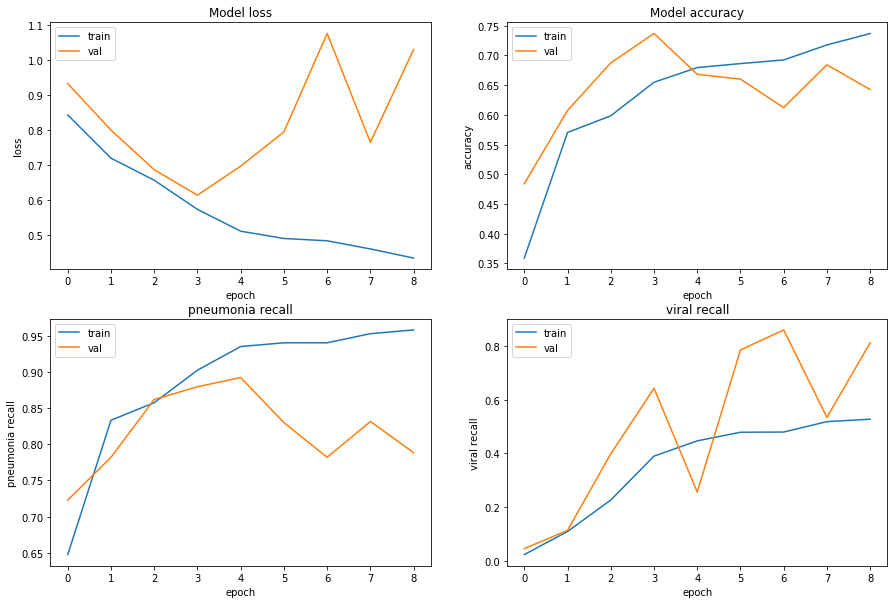

In [ ]:
#plot_hist(ushistory2.history)
plot_hist(us_hist)

In [ ]:
#save history and model
pd.DataFrame(ushistory2.history).to_csv('us_hist.csv')
model_us.save('us.h5')

## Pre-trained model

### Xception
At first,we set the layers of xception as non-trainable to do transfer learning.

In [ ]:
#分类recall，病毒性肺炎recall，总肺炎阳性recal
virusrecall=keras.metrics.Recall(class_id=1,name='viral_recall')
normrecall=keras.metrics.Recall(class_id=2,name='norm_recall')
Precall=keras.metrics.Recall( top_k=2,name='P_recall')

In [ ]:
#新的模型定义代码，如果想换别的模型的话也要这么写
xception=keras.applications.Xception(input_shape=(150,150,3),include_top=False,)
mid=keras.layers.GlobalAveragePooling2D()(xception.output)
mid=keras.layers.BatchNormalization()(mid)
mid=keras.layers.Dropout(0.1)(mid)
mid=keras.layers.Dense(1024,activation='relu')(mid)
mid=keras.layers.Dense(512,activation='relu')(mid)
mid=keras.layers.Dense(128,activation='relu')(mid)
output=keras.layers.Dense(3,activation='softmax')(mid)

#冻结迁移学习层权重
for layer in xception.layers:
    layer.trainable = False

model_xception=keras.models.Model(inputs=xception.input,outputs=output,name='xception2')
model_xception.compile(loss='categorical_crossentropy',metrics=['categorical_accuracy',virusrecall,Precall,normrecall],
                optimizer='adam')

In [ ]:
model_xception.summary()

Model: "xception2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 74, 74, 32)   864         input_3[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 74, 74, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 74, 74, 32)   0           block1_conv1_bn[0][0]            
__________________________________________________________________________________________

In [ ]:
#model_bestxception.evaluate(validation_generator)

In [ ]:
#冻结的训练记录
callback = myEarlyStopping(5)
history4=model_xception.fit(trainaug_generator,epochs=30,validation_data=validation_generator,class_weight=class_weight,callbacks=[callback])

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 41 steps, validate for 20 steps
Epoch 1/30
41/41 [==============================] - 83s 2s/step - loss: 0.6060 - categorical_accuracy: 0.6317 - viral_recall: 0.4900 - P_recall: 0.9084 - norm_recall: 0.7763 - val_loss: 0.7781 - val_categorical_accuracy: 0.3942 - val_viral_recall: 0.2838 - val_P_recall: 0.8253 - val_norm_recall: 0.2479
Epoch 2/30
41/41 [==============================] - 80s 2s/step - loss: 0.4680 - categorical_accuracy: 0.7015 - viral_recall: 0.5442 - P_recall: 0.9440 - norm_recall: 0.8688 - val_loss: 0.7214 - val_categorical_accuracy: 0.5433 - val_viral_recall: 0.0473 - val_P_recall: 0.8750 - val_norm_recall: 0.5470
Epoch 3/30
41/41 [==============================] - 80s 2s/step - loss: 0.4502 - categorical_accuracy: 0.7151 - viral_recall: 0.5636 - P_recall: 0.9492 - norm_recall: 0.8911 - val_loss: 0.7412 - val_categorical_accuracy: 0.4215 - val_viral_recall: 0.7770 - val_P_recall: 0.8333 - val_norm_recall: 0.3

In [ ]:
model_xception_false=keras.models.load_model('lastfalsexception.h5')
xception_false_hist=pd.read_csv('false_hist.csv')

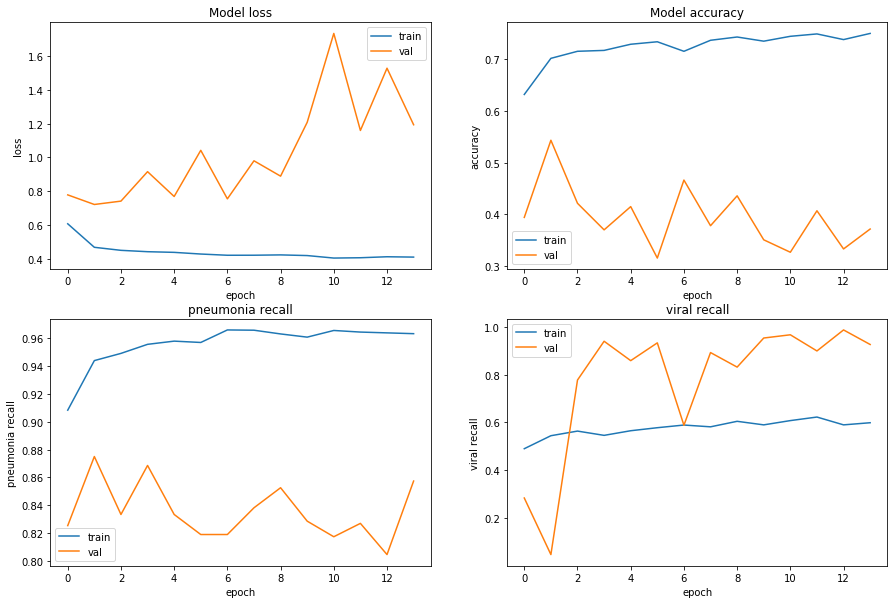

In [ ]:
#plot_hist(history4.history)
plot_hist(xception_false_hist)

In [ ]:
pd.DataFrame(history4.history).to_csv('false_hist.csv')

In [ ]:
model_xception.save('lastfalsexception.h5')

Then, we found that the performance of the model was not ideal, so we set the layers of xception as trainable in order to get better performance.

In [ ]:
#新的模型定义代码，如果想换别的模型的话也要这么写
xception=keras.applications.Xception(input_shape=(150,150,3),include_top=False,)
mid=keras.layers.GlobalAveragePooling2D()(xception.output)
mid=keras.layers.BatchNormalization()(mid)
mid=keras.layers.Dropout(0.1)(mid)
mid=keras.layers.Dense(1024,activation='relu')(mid)
mid=keras.layers.Dense(512,activation='relu')(mid)
mid=keras.layers.Dense(128,activation='relu')(mid)
output=keras.layers.Dense(3,activation='softmax')(mid)

#不冻结迁移学习层权重
for layer in xception.layers:
    layer.trainable = True

model_xception=keras.models.Model(inputs=xception.input,outputs=output,name='xception2')
model_xception.compile(loss='categorical_crossentropy',metrics=['categorical_accuracy',virusrecall,Precall,normrecall],
                optimizer='adam')

In [ ]:
#不冻结
callback = myEarlyStopping(5)
history4=model_xception.fit(trainaug_generator,epochs=30,validation_data=validation_generator,class_weight=class_weight,callbacks=[callback])

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 41 steps, validate for 20 steps
Epoch 1/30
41/41 [==============================] - 87s 2s/step - loss: 0.4556 - categorical_accuracy: 0.7216 - viral_recall: 0.5926 - P_recall: 0.9628 - norm_recall: 0.9053 - val_loss: 0.4943 - val_categorical_accuracy: 0.7212 - val_viral_recall: 0.2500 - val_P_recall: 0.9038 - val_norm_recall: 0.9402
Epoch 2/30
41/41 [==============================] - 81s 2s/step - loss: 0.3350 - categorical_accuracy: 0.7755 - viral_recall: 0.7100 - P_recall: 0.9879 - norm_recall: 0.9553 - val_loss: 0.3865 - val_categorical_accuracy: 0.8542 - val_viral_recall: 0.6216 - val_P_recall: 0.9503 - val_norm_recall: 0.9060
Epoch 3/30
41/41 [==============================] - 81s 2s/step - loss: 0.2963 - categorical_accuracy: 0.7987 - viral_recall: 0.7405 - P_recall: 0.9912 - norm_recall: 0.9761 - val_loss: 0.5015 - val_categorical_accuracy: 0.8269 - val_viral_recall: 0.3243 - val_P_recall: 0.9728 - val_norm_recall: 0.9

In [ ]:
model_xception_true=keras.models.load_model('lasttruexception.h5')
xception_true_hist=pd.read_csv('True_hist.csv')

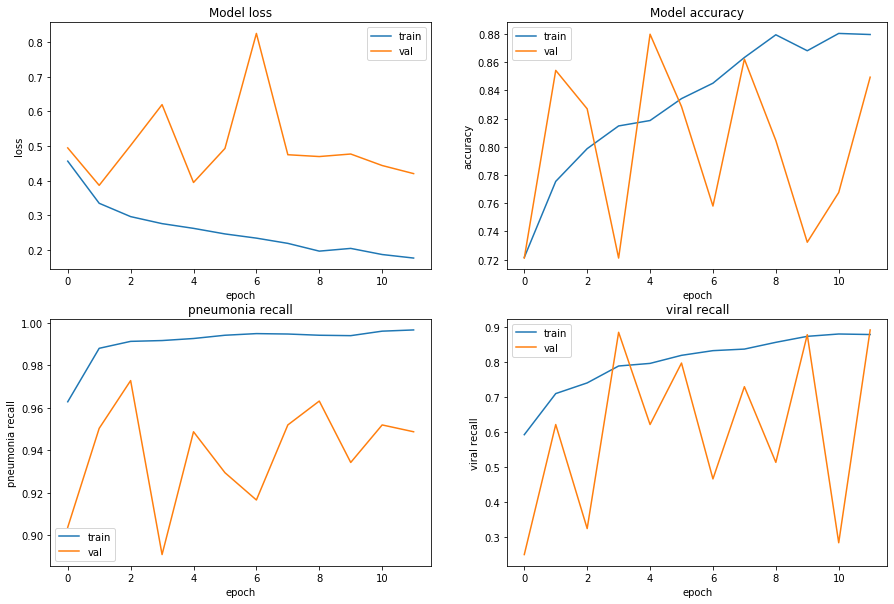

In [ ]:
#plot_hist(history4.history)
plot_hist(xception_true_hist)

In [ ]:
pd.DataFrame(history4.history).to_csv('True_hist.csv')

In [ ]:
model_xception.save('lasttruexception.h5')

## Evaluation of Prediction on test set
In this section, we use confusion matrix, recall and accuracy to evaluate our model.

Below are some helper functions

In [ ]:
def get_dataframe(validation_generator,res):
    '''Get the labels of the generator and combine it with prediction in to a DataFrame'''
    number_of_generator_calls = math.ceil(624/ (1.0 * 32)) 
    test_labels = []
    for i in range(0,int(number_of_generator_calls)):
        test_labels.extend(np.array(validation_generator[i][1]))
    test_labels=np.array(test_labels)
    testdata=pd.DataFrame({'True':test_labels.argmax(axis=1),'predict':res.argmax(axis=1)})
    return testdata

def confusion_matrix_show(ma,classes):
    seaborn.heatmap(ma,annot=True,fmt='d',xticklabels=classes,yticklabels=classes)
    plt.xlabel('Predict')
    plt.ylabel('True')
    plt.title('Confusion matrix')
    plt.show()

def evaluate(testdata,classes):
    '''Get confusion matrix and Caculate recall of each class'''
    ma=confusion_matrix(testdata['True'],testdata['predict'])
    confusion_matrix_show(ma,classes)
    #print("onfusion_matrix:\n",ma)
    num=ma.sum(axis=1)
    pbac=round(ma[0][0]/num[0],3)*100
    pvac=round(ma[1][1]/num[1],3)*100
    pnac=round(ma[2][2]/num[2],3)*100
    trecall=round(1-(ma[0][2]+ma[1][2])/(num[0]+num[1]),3)*100
    acc=round(accuracy_score(testdata['True'],testdata['predict']),2)*100
    print('\n bacteria recall:{}%\n virus recall:{}%\n normal recall:{}% \n total recall:{}%\n acc: {}%'.format(pbac,pvac,pnac,trecall,acc))
    

def model_evaluator(model,validation_generator):
    res=model.predict(validation_generator)
    testdata=get_dataframe(validation_generator,res)
    evaluate(testdata,validation_generator.class_indices.keys())
    return testdata
    

In [ ]:
#drive
def get_dataframe(validation_generator,res):
    '''Get the labels of the generator and combine it with prediction in to a DataFrame'''
    number_of_generator_calls = math.ceil(624/ (1.0 * 32)) 
    test_labels = []
    for i in range(0,int(number_of_generator_calls)):
        test_labels.extend(np.array(validation_generator[i][1]))
    test_labels=np.array(test_labels)
    testdata=pd.DataFrame({'True':test_labels.argmax(axis=1),'predict':res.argmax(axis=1)})
    return testdata

def confusion_matrix_show(ma,classes):
    seaborn.heatmap(ma,annot=True,fmt='d',xticklabels=classes,yticklabels=classes)
    plt.xlabel('Predict')
    plt.ylabel('True')
    plt.title('Confusion matrix')
    plt.show()

def evaluate(testdata,classes):
    '''Get confusion matrix and Caculate recall of each class'''
    ma=confusion_matrix(testdata['True'],testdata['predict'])
    confusion_matrix_show(ma,classes)
    #print("onfusion_matrix:\n",ma)
    num=ma.sum(axis=1)
    pbac=round(ma[0][0]/num[0],3)*100
    pvac=round(ma[1][1]/num[1],3)*100
    pnac=round(ma[2][2]/num[2],3)*100
    trecall=round(1-(ma[0][2]+ma[1][2])/(num[0]+num[1]),3)*100
    acc=round(accuracy_score(testdata['True'],testdata['predict']),2)*100
    print('\n bacteria recall:{}%\n virus recall:{}%\n normal recall:{}% \n total recall:{}%\n accuracy: {}%'.format(pbac,pvac,pnac,trecall,acc))
    

def model_evaluator(model,validation_generator):
    res=model.predict(validation_generator)
    testdata=get_dataframe(validation_generator,res)
    evaluate(testdata,validation_generator.class_indices.keys())
    return testdata

Evaluation of our own model.

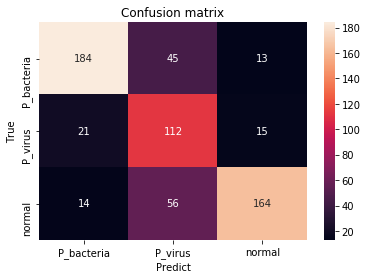


 bacteria recall:76.0%
 virus recall:75.7%
 normal recall:70.1% 
 total recall:92.80000000000001%
 accuracy: 74.0%


In [ ]:
test_resus=model_evaluator(model_us,validation_generator)
#这里会返回一个dataframe，包含预测label和正确label,后面会用到的

Evaluation of Xception model(写一段评价)

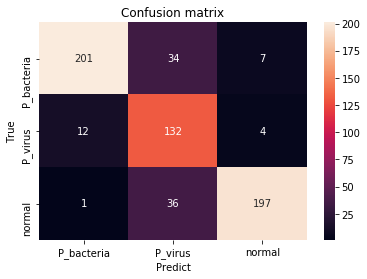


 bacteria recall:83.1%
 virus recall:89.2%
 normal recall:84.2% 
 total recall:97.2%
 accuracy: 85.0%


In [ ]:
xtest_res=model_evaluator(model_xception_true,validation_generator)

In [ ]:
xtest_res.head()

,True,predict
0,0,0
1,1,1
2,2,1
3,2,2
4,0,0


## Visualizing the Model
In this section, we visualize the itermediate activation layers and display saliency and grad-cam maps of our models to explore and validate models' performance

In [ ]:
wrong_indexs=xtest_res[xtest_res['True']!=xtest_res['predict']].index
#get all indexs of wrong sample
right_indexs=xtest_res[xtest_res['True']==xtest_res['predict']].index
#get all indexs of right sample

In [ ]:
def plot_feature_maps(model,validation_generator,test_res,index,layer_ids):
    '''test_res is a dataframe of ture label and predict label of test dataset'''
    transdic=validation_generator.class_indices
    transdic=dict(zip(transdic.values(),transdic.keys()))
    # get the translation dict of class index to class name
    batch=index//32
    i=index%32
    image=validation_generator[batch][0][i:i+1]
    if test_res.iloc[index,0]==test_res.iloc[index,1]:
        a='Right'
    else:
        a='Wrong'
    text=a+' Sample'+' | '+'True Class:'+transdic[test_res.iloc[index,0]]+' | '+'Predict Class: '+transdic[test_res.iloc[index,1]]

    if test_res.iloc[index,0]==test_res.iloc[index,1]:
        a='Right'
    else:
        a='Wrong'
    text=a+' Sample'+' | '+'True Class:'+transdic[test_res.iloc[index,0]]+' | '+'Predict Class: '+transdic[test_res.iloc[index,1]]

    print("---------------")
    print(text)
    print("---------------")
    plt.imshow(image[0])
    plt.show()
    
    #批处理
    for layer_id in layer_ids:
      feature_maps = get_feature_maps(model,layer_id,image)
      print(feature_maps.shape)
      print("---------------")
      print(model.layers[layer_id].name)
      print("---------------")
      fig, ax = plt.subplots(3,3, figsize=(8,8))
      for i, axis in enumerate(ax.ravel()):
          axis.imshow(feature_maps[i], cmap='gray')
          if(i==9): break
      plt.show();
def get_feature_maps(model,layer_id,image):
  intermediate = keras.Model(inputs=model.input,outputs=[model.layers[layer_id].output])
  return intermediate.predict(image)[0,:,:,:].transpose((2,0,1))

We choose 5 intermediate layers for each model. 


For xception, we choose 1,13,23,33,123rd layers, which are maxpooling layers as well.

At the early layers, the model seems attempting to detect edges. Some of them highlight ribs or oragans, ohters differentiate the body and the enviroment. As the model goes deeper, the model become more and more blured and abstract. At the end, the image become several pixels.

---------------
Right Sample | True Class:P_virus | Predict Class: P_virus
---------------


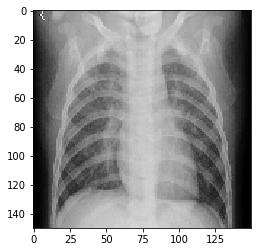

(32, 74, 74)
---------------
block1_conv1
---------------


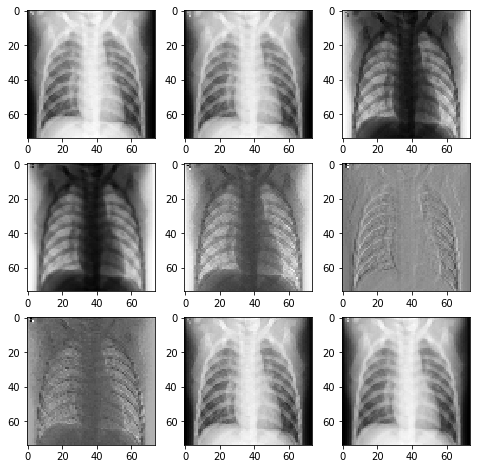

(128, 36, 36)
---------------
block2_pool
---------------


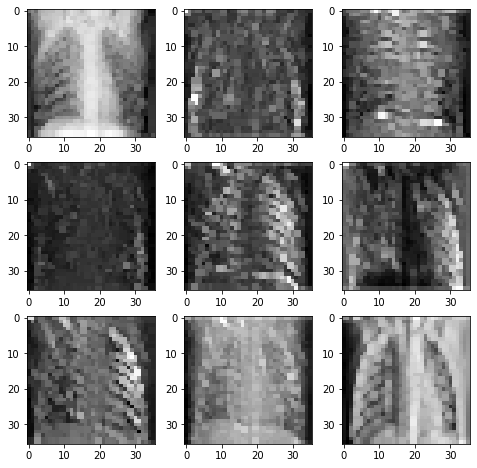

(256, 18, 18)
---------------
block3_pool
---------------


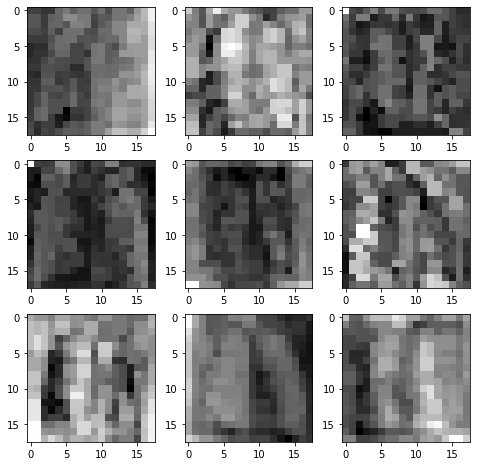

(728, 9, 9)
---------------
block4_pool
---------------


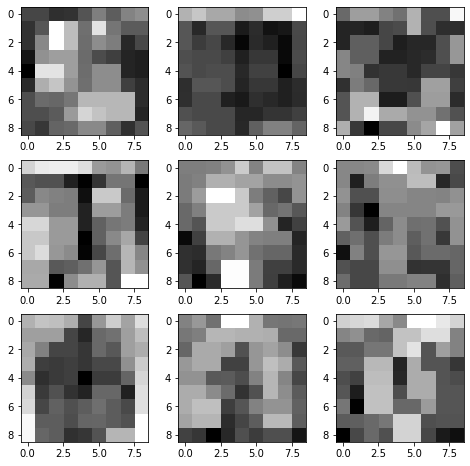

(1024, 5, 5)
---------------
block13_pool
---------------


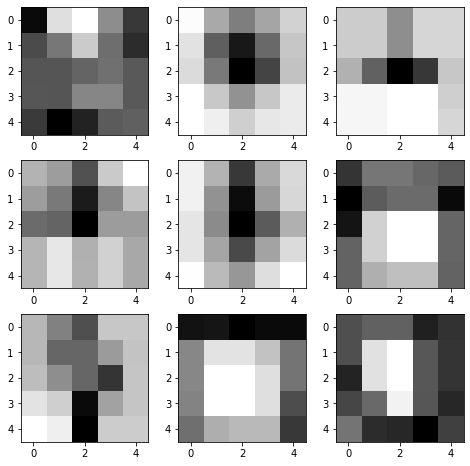

In [ ]:
plot_feature_maps(model_xception,validation_generator,xtest_res,right_indexs[0],[1,13,23,33,123])

We apply two popular techniques to visualize our model. The first method is the saliency map, which, according to the specific class and image, gives the rank of saliency of each pixel(Simonyan et al., 2013). The second method is the grad cam, which calculates the average gradient of a class with respect to each chanel in a certain layer(Selvaraju et al., 2017).

In [ ]:
def model_modifier(m):
    m.layers[-1].activation = keras.activations.linear
def model_recover(m):
    '''For the recovering of model destoryed by model_modifier'''
    m.layers[-1].activation = keras.activations.softmax
def loss(output):
    return output

In [ ]:

def saliencyMap(model,image):
    saliency = Saliency(model, model_modifier,clone=True)
    pred = model.predict(image)
    pred_id = np.argmax(pred) 
    newloss=lambda output: keras.backend.mean(output[:, pred_id])
    saliency_map = saliency(newloss, image, smooth_samples=20)
    saliency_map = normalize(saliency_map)
    return saliency_map

def gradCam(model,image):
    gradcam = Gradcam(model,model_modifier=model_modifier,clone=True)
    cam = gradcam(loss,image.astype('float'),penultimate_layer=-1, )
    cam = normalize(cam)
    return cam

def basic_plot_grad_saliency(model,image,text):
    #plot grad-cam and saliency map
    subplot_args = { 'nrows': 1, 'ncols': 3, 'figsize': (15,5),
                 'subplot_kw': {'xticks': [], 'yticks': []} }
    fig,ax=plt.subplots(**subplot_args)
    saliency_map=saliencyMap(model,image)
    cam=gradCam(model,image)
    #print(text)
    fig.suptitle(text)
    ax[0].imshow(image[0])
    ax[0].set_title('Original')
    
    ax[1].imshow(saliency_map[0],cmap='jet')
    ax[1].set_title('Saliency map')
    
    ax[2].imshow(image[0])
    ax[2].imshow(cam[0],alpha=0.4,cmap='jet')
    ax[2].set_title('Grad-cam')
    #plt.show()
    
def plot_grad_saliency(model,validation_generator,test_res,index):
    '''test_res is a dataframe of ture label and predict label of test dataset'''
    transdic=validation_generator.class_indices
    transdic=dict(zip(transdic.values(),transdic.keys()))
    # get the translation dict of class index to class name
    batch=index//32
    i=index%32
    image=validation_generator[batch][0][i:i+1]
    if test_res.iloc[index,0]==test_res.iloc[index,1]:
        a='Right'
    else:
        a='Wrong'
    text=a+' Sample'+' | '+'True Class:'+transdic[test_res.iloc[index,0]]+' | '+'Predict Class: '+transdic[test_res.iloc[index,1]]
    basic_plot_grad_saliency(model,image,text)

The following images are generated by one correctly predicted sample. As we could see, the grad-cam shows the model focuses on the upper part of the lungs around the trachea. Clearly, it gets the correct features that there are shadows in the upper part making the floral margins unclear like the normal one.

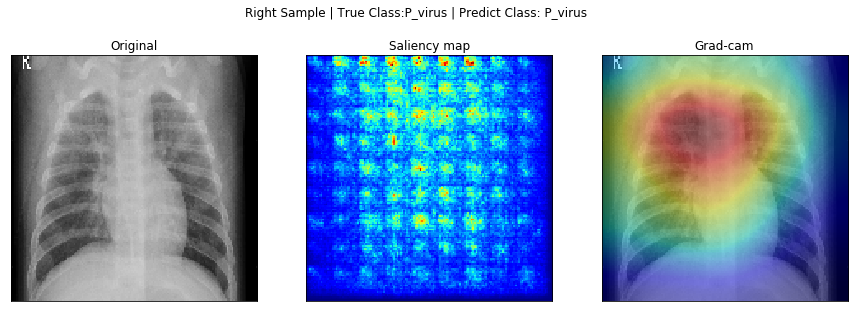

In [ ]:
plot_grad_saliency(model_xception,validation_generator,xtest_res,right_indexs[20])

However, in some correctly classified samples, the model does not focus on the correct area. When the left heart border blurred, the model focuses on the right pulmonary angle, suggesting there is something flawed even the prediction is right.

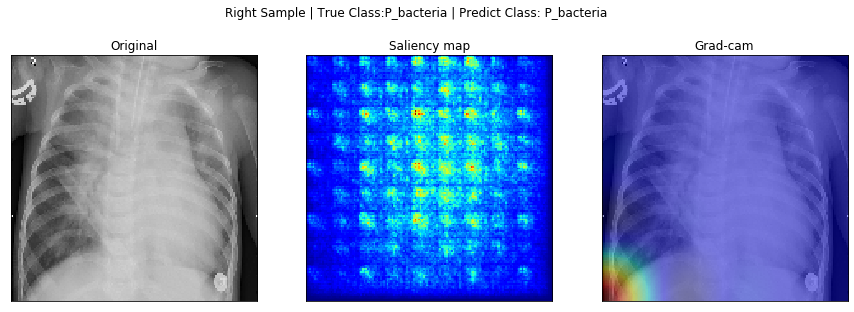

In [ ]:
plot_grad_saliency(model_xception,validation_generator,xtest_res,right_indexs[80])

In the wrongly predicted on, the model is even more ridiculous that focuses on shoulders instead of lungs.

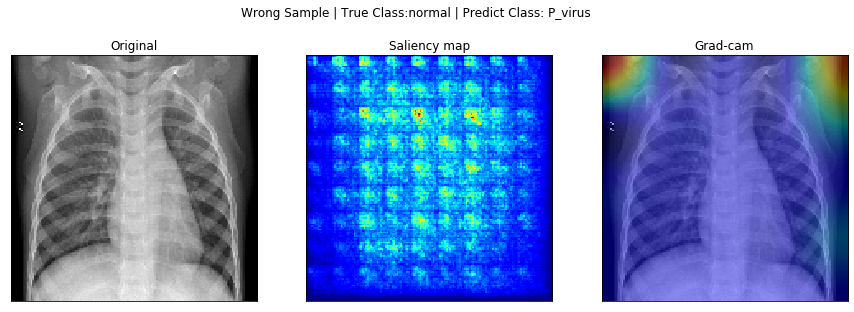

In [ ]:
plot_grad_saliency(model_xception,validation_generator,xtest_res,wrong_indexs[0])

## Conculusion and Futher works

Judging from the evaluation index, our model has accomplished this task quite well. The accuracy rate was 83 percent, the viral pneumonia recall was more than 80 percent, and the pneumonia overall recall was more than 90 percent. Such a performance model has been able to play a limited role in assisting radiologists in pre-screening patients in the early stages of an outbreak. But when we visually analyzed the model, we found that for many of the correctly classified samples, the model didn't look at the lungs, it looked at something else and got the answer right. This is a very bad phenomenon, which indicates that there is great uncertainty in the model. If other data is encountered, it may not perform so well. We analyzed that this was probably influenced by the data set we chose. Our data set's chest radiographs from children between the ages of one and five, but the bodies of children between the ages of one and five are growing rapidly, so the gap between samples can be large.Besides , the length-to-width ratio gap between samples is also quite large, so if we cast into a square may cause loss of some features.
 
So our next priority is to find a more appropriate training set, especially for adult chest radiographs. We have found the largest chest radiograph data set published by NIH Clinical Center to date, which includes a large number of samples of 10 different diseases. However, it only has the label of pneumonia and does not distinguish between viral and bacterial, so we also need a real radiologist to help us distinguish these samples and build the data set needed for this project. With more data, our model may perform better.
 
 Additionally, just as the purpose of this dataset is to create a high precision computer-aided diagnosis (CAD) system, we want to create a new model to classify all diseases in this dataset. In fact, an article was published on this topic in CVPR2017, which also provides the labels of this dataset by NLP. They have tried Alexnet,GoogLeNet,VGG16 and ResNet-50 on this dataset, in which the best one is ResNet-50, but its accuracy is far from practical. So our future task is to use their work as baseline to continue to try other models, or modify some existing models to achieve higher accuracy.



## Referance

NIH Chest X-rays
https://www.kaggle.com/nih-chest-xrays/data?select=images_012
https://www.nih.gov/news-events/news-releases/nih-clinical-center-provides-one-largest-publicly-available-chest-x-ray-datasets-scientific-community

Wang X, Peng Y, Lu L, Lu Z, Bagheri M, Summers RM. ChestX-ray8: Hospital-scale Chest X-ray Database and Benchmarks on Weakly-Supervised Classification and Localization of Common Thorax Diseases. IEEE CVPR 2017, http://openaccess.thecvf.com/content_cvpr_2017/papers/Wang_ChestX-ray8_Hospital-Scale_Chest_CVPR_2017_paper.pdf

Selvaraju, R. R., Cogswell, M., Das, A., Vedantam, R., Parikh, D., & Batra, D. (2017). Grad-cam: Visual explanations from deep networks via gradient-based localization. Proceedings of the IEEE International Conference on Computer Vision, 618–626.

Simonyan, K., Vedaldi, A., & Zisserman, A. (2013). Deep inside convolutional networks: Visualising image classification models and saliency maps. ArXiv Preprint ArXiv:1312.6034.